In [2]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [3]:
#this means only look at top ten frequencies/peaks
MAX_FREQS_PER_STAR = 10

In [4]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()


In [5]:
#array of time differences, find its median, use it to calculate the max frequency
lc = lc_collection.stitch()  # Combine all light curves in lc_collection
sampling_rate_days= np.median(np.diff(lc.time))
sampling_rate_days_no_units = sampling_rate_days.value #get rid of units
f_max = 1 / (sampling_rate_days) #in days
f_max_no_units = f_max.value #get rid of units (but it's actually in 1/days)

print(sampling_rate_days_no_units)
print(f_max_no_units)
print(sampling_rate_days)



0.02043360086827306
48.93900034783809
0.02043360086827306


In [6]:
#check there is no unit
print(type(f_max_no_units), type(sampling_rate_days_no_units))


<class 'numpy.float64'> <class 'numpy.float64'>


In [7]:
#find total observation time, use it to find minimum frequency
total_observation_time = lc.time[-1] - lc.time[0] # in days
f_min = f_min = 1/ total_observation_time # in days
f_min_no_units = f_min.value #strip units (but are in 1/days)
print(f_min_no_units)
print(type(f_min_no_units))

0.0006800582572566702
<class 'numpy.float64'>


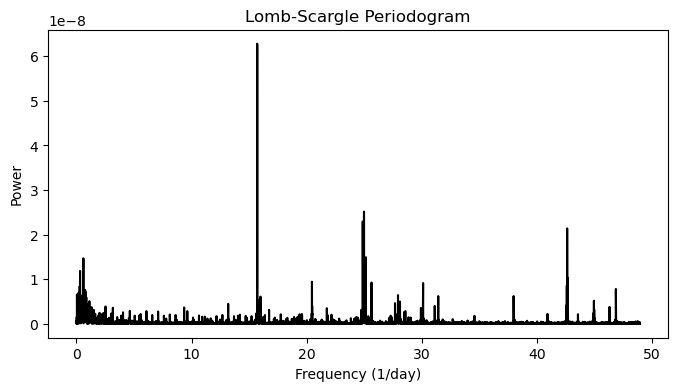

In [8]:
#trying to create periodograms with no units by manually plotting
#use lightcurve called lc to make periogram pg
pg = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    minimum_frequency=f_min_no_units,
    maximum_frequency=f_max_no_units
)

power_no_units = np.array(pg.power.value) # an array of powers of the ligthcurve
freq_no_units = np.array(pg.frequency.value) # array of freqs of lightcurve
plt.figure(figsize=(8, 4))
plt.plot(freq_no_units, power_no_units, 'k-')  # Black line
plt.xlabel("Frequency (1/day)") 
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()



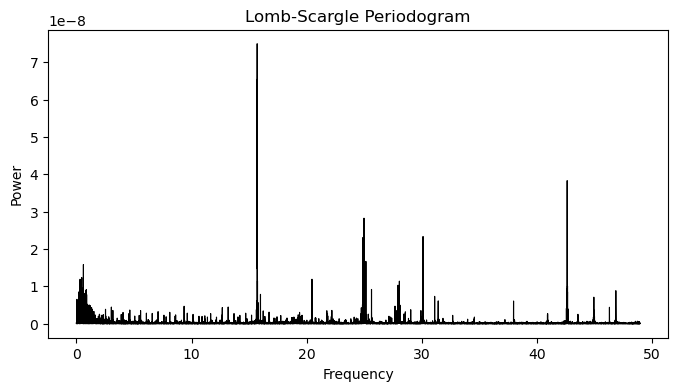

In [9]:
#trying to create periodograms of spacing f_min
frequency_grid = np.arange(f_min_no_units, f_max_no_units, f_min_no_units) #spacing with increments of f_min, starting with f_min_no_units to avoid di

#create periodogram only to get values in order to remove units
pg_spacing_fmin = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid  # Unitless frequency grid
)

freq_values = np.array(pg_spacing_fmin.frequency.value)  # Remove units, use this later in get_started function as x values
power_values = np.array(pg_spacing_fmin.power.value)  # Remove units, use this later in get_started function as y values

plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(freq_values, power_values, 'k-', lw=0.8) 
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

plt.show()




In [10]:
def find_nanapeaks(num_of_peaks, xs, ys): 
    """
    
    reorders them from high peak to lowest peaks
    
    """
    indxs, properties = find_peaks(ys)
    sindx = np.argsort(-ys[indxs])[:num_of_peaks]
    return (xs[indxs[sindx]], ys[indxs[sindx]],indxs[sindx])

In [11]:
import nana #all of the functions and it's specifics are in the github jupyter notebook

In [12]:
nana.check_inputs(freq_values) #this checks if the frequencies are in ascending order which you need to do before 
#using the get_started() function

True

In [13]:
indices = nana.get_started(MAX_FREQS_PER_STAR, freq_values, power_values) #this function returns
#the indices of the 10 highest peaks given the frequency and powers that we got from the periodogram

In [14]:
print(indices) #seems to be working
#testing

[23088 23103 62667 36727 44265 36563 36970   904   690 30084]


In [22]:
xs_refined, ys_refined, second_derivatives = nana.refine_peaks(freq_values, power_values, indices) # this returns the new x values 
#and the new y values, and second derivatives


In [24]:
print(xs_refined, ys_refined, second_derivatives) #derivatives are all negative --> good sign

[15.70184503 15.71217506 42.61760861 24.9770961  30.10343601 24.86568309
 25.14225572  0.61572691  0.46996823 20.45969442] [7.50007976e-08 6.55488932e-08 3.85119572e-08 2.82718702e-08
 2.33626489e-08 2.30454510e-08 1.67248546e-08 1.59238917e-08
 1.23673035e-08 1.19277569e-08] [-0.01049853 -0.00919472 -0.00463524 -0.00252564 -0.00260631 -0.00293977
 -0.0018465  -0.00208434 -0.00181926 -0.00124611]


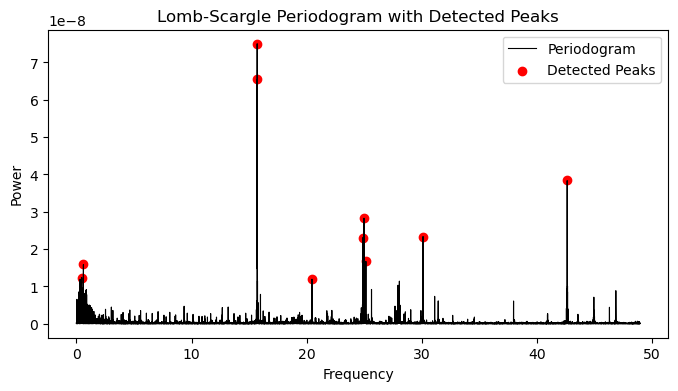

In [28]:
#marking the refined peaks that we found

plt.figure(figsize=(8, 4))

plt.plot(freq_values, power_values, 'k-', lw=0.8, label="Periodogram")

plt.scatter(xs_refined, ys_refined, color='red', marker='o', label="Detected Peaks")

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram with Detected Peaks")
plt.legend()

plt.show()
